# CI6227 Data Mining – Assignment 2
## Ashish Narmen, G1901836L

In [ ]:
import pandas
import itertools
import copy
import math
from apyori import apriori
import datetime
import matplotlib.pyplot as plt
import numpy as np

# Data Preprocessing

## Annotate trip data with time segment 

In [34]:
def gen_time_segment(dt):
    if dt.minute < 30:
        minute = "%02d" % 0
    else:
        minute = "%02d" % 30
    return "{}-{}-{} {}:{}".format(dt.year, dt.month, dt.day, dt.hour, minute)

def process_trip_data(tripdata_csv_file):
    data_frame_trip_data = pandas.read_csv(tripdata_csv_file)
    data_frame_trip_data.dropna(axis=1, how='any')

    data_frame_trip_data['starttime'] = pandas.to_datetime(data_frame_trip_data['starttime'], format='%Y-%m-%d %H:%M:%S')
    data_frame_trip_data['stoptime'] = pandas.to_datetime(data_frame_trip_data['stoptime'], format='%Y-%m-%d %H:%M:%S')
    data_frame_trip_data['start_seg'] = [gen_time_segment(dt) for dt in data_frame_trip_data['starttime']]
    data_frame_trip_data['stop_seg'] = [gen_time_segment(dt) for dt in data_frame_trip_data['stoptime']]
    return data_frame_trip_data

## Group and Count the data according to the time segments

In [ ]:
def get_station_id_list_and_inflow_and_outflow(data_frame_trip_data):
    t1 = data_frame_trip_data[['start station id', 'start station name', 'start station latitude', 'start station longitude']] \
            .drop_duplicates().rename(columns = {'start station id':'station id', \
                                                    'start station name':'station name', \
                                                    'start station latitude':'station latitude', 
                                                    'start station longitude': 'station longitude'})
    t2 = data_frame_trip_data[['end station id', 'end station name', 'end station latitude', 'end station longitude']] \
            .drop_duplicates().rename(columns = {'end station id':'station id', \
                                            'end station name':'station name', \
                                            'end station latitude':'station latitude', \
                                            'end station longitude': 'station longitude'})
    df_loc = pandas.concat([t1, t2]).drop_duplicates()
    inflow = data_frame_trip_data[['end station id', 'stop_seg']] \
            .groupby(['end station id', 'stop_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'end station id':'station id','stop_seg':'time', 'counts':'in_flow_count'})


    outflow = data_frame_trip_data[['start station id', 'start_seg']] \
            .groupby(['start station id', 'start_seg']) \
            .size().reset_index(name='counts') \
            .rename(columns={'start station id':'station id','start_seg':'time', 'counts':'out_flow_count'})

    station_id_list = list(df_loc['station id'])
    return station_id_list, inflow, outflow

## Merge the in-flow and out-flow across time segments for each station

In [35]:
def extract_in_out_flows(start_date, end_date, station_id_list, inflow, outflow ):
    # Create combinations of time series and station ids
    time_seg_list = list(pandas.date_range(start_date, end_date, freq="30min"))
    template = pandas.DataFrame(list(itertools.product(station_id_list, time_seg_list)), \
                            columns=["station id", "time"])

    # Merge in/out flow information & Add zeros to missing data according to every time segment
    dat = pandas.merge(inflow, outflow, on=['station id', 'time'], how='outer')
    dat['time'] = pandas.to_datetime(dat['time'], format='%Y-%m-%d %H:%M')
    dat = dat.merge(template, on=["station id", "time"], how="right").fillna(0)
    return dat

# Define Transactions
* Station ID
* Time of the day 
* Flow count 


## Discretization Method
* Morning 
* Noon 
* Afternoon
* Evening 
* Night

In [36]:
def get_station_specific_data(df_flow, station_id):
    df_flow['time'] = pandas.to_datetime(df_flow['time'], format='%Y-%m-%d %H:%M:%S')
    dat = df_flow[df_flow['station id'] == station_id][['time', 'in_flow_count', 'out_flow_count']]
    dat['flow_count'] = dat['in_flow_count'] + dat['out_flow_count']
    dat['time'] = ["{:02d}:{:02d}".format(dt.hour, dt.minute) for dt in dat['time']]
    dat = dat[['time', 'flow_count']]
    dat['time'] = pandas.to_datetime(dat['time'], format='%H:%M')
    dat_copy = copy.deepcopy(dat)
    mapping = ["Night"]*6 + ["Morning"]*5 + ["Noon"]*2 + ["Afternoon"]*3 + ["Evening"]*6 + ["Night"]*2
    dat_copy['time'] = [mapping[math.floor(dt.hour)] for dt in dat_copy['time']]
    dat_copy['flow_count'] = pandas.qcut(dat_copy['flow_count'], q = 3, \
                                    labels = ["low", "medium", "high"]).astype(str)
    pandas.qcut(dat['flow_count'], q = 3).value_counts()
    return dat_copy

In [ ]:
def get_data_frames_start_end_dates_and_station_ids(start_date, end_dates, station_ids):
    data_frames = []
    for end_date, station_id in zip(end_dates, station_ids):
      df_flow = extract_in_out_flows(start_date, end_date, station_id_list=station_id_list, inflow=inflow, outflow=outflow)
      data_frame = get_station_specific_data(df_flow, station_id)
      data_frames.append(data_frame)
    return data_frames

In [28]:
tripdata_csv_file = 'data/201707-citibike-tripdata.csv'
data_frame_trip_data = process_trip_data(tripdata_csv_file=tripdata_csv_file)
station_id_list, inflow, outflow = get_station_id_list_and_inflow_and_outflow(data_frame_trip_data=data_frame_trip_data)
start_date = "2017-07-01 00:00:00"
end_dates = ["2017-07-06 23:30:00", "2017-07-12 23:30:00", "2017-07-18 23:30:00", "2017-07-24 23:30:00", "2017-07-30 23:30:00"]
station_ids = [519, 502, 382, 3416, 293]
data_frames = get_data_frames_start_end_dates_and_station_ids(start_date, end_dates, station_ids)

# Association Rule Mining 


## Performance Logs 
* 75 iterations

In [ ]:
def get_counts_and_perf_logs(data_frames, fn):
    cols = set()
    perf_logs = []
    for _ in range(0, 75):
      time_log = []
      for data_frame in data_frames:
        cols.add(len(data_frame.index))
        start_time = datetime.datetime.now()
        fp = fn(data_frame.values.tolist(), 0.05, 0.6)
        end_time = datetime.datetime.now()
        time_taken = end_time - start_time
        time_log.append(time_taken.microseconds)
      perf_logs.append(time_log)
    perf_logs = np.array(perf_logs)
    cols = sorted(list(cols))
    return cols, perf_logs

def draw_box_plot(cols, perf_logs):
    df = pandas.DataFrame(perf_logs,columns=cols)
    boxplot = df.boxplot(column=cols)
    boxplot.set_xlabel('Counts')
    boxplot.set_ylabel('Time (in microseconds)')
    return boxplot

## Apriori Algorithm

In [29]:
def apriori_find_association_rules(dataset, minsup, minconf):
    records = list(apriori(dataset, min_support=minsup, min_confidence=minconf))
    return records

def apriori_show_mining_results(records):
    ap = []
    for record in records:
        converted_record = record._replace(ordered_statistics=[x._asdict() for x in record.ordered_statistics])
        ap.append(converted_record._asdict())
    
    print("Frequent Itemsets:\n------------------")
    for ptn in ap:
       print('({})  support = {}'.format(", ".join(ptn["items"]), round(ptn["support"], 3)))
    print()
    
    print("Rules:\n------")
    for ptn in ap:
        for rule in ptn["ordered_statistics"]:
            head = rule["items_base"]
            tail = rule["items_add"]
            if len(head) == 0 or len(tail) == 0:
                continue
            confidence = rule["confidence"]
            print('({}) ==> ({})  confidence = {}'.format(', '.join(head), ', '.join(tail), round(confidence, 3)))
    print()

### Box Plots

<AxesSubplot:xlabel='Counts', ylabel='Time (in microseconds)'>

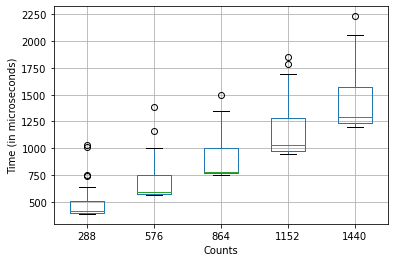

In [62]:
apriori_cols, apriori_perf_logs = get_counts_and_perf_logs(data_frames, apriori_find_association_rules)
draw_box_plot(apriori_cols, apriori_perf_logs)

## Brute Force Approach

In [50]:
def brute_force_association_mining(dataset, minsup, minconf):
	dataset = np.array(dataset)
	df = pandas.DataFrame(dataset)
	itemset = set()
	for col in df:
		itemset.update(df[col].unique())
	items = sorted(list(itemset))
	ic = len(items)
	tc = len(df.index)
	trans=[]
	for index, row in df.iterrows():
		tran= [0] * len(itemset)
		rowset = set(row)
		commons = list(itemset.intersection(rowset))
		for com in commons:
			com_index = items.index(com)
			tran[com_index] = 1
			trans.append(tran)

	trans1=[]
	for x in range(tc):
		tran1=[]
		for y in range(ic):
			if(trans[x][y]==1):
				tran1.append(y)
		trans1.append(set(tran1))

	L=[]
	for l in range(1,ic+1):
		for subset in itertools.combinations(range(ic),l):
			L.append(set(subset))

	LC=[]
	for l in L:
		lc=0
		for t in trans1:
			if(l.issubset(t)):
				lc+=1
		LC.append(lc)
	C=[]
	CC=[]
	for x in range(len(LC)):
		if(LC[x]>=minsup):
			C.append(list(L[x]))
			CC.append(LC[x])
	LHS = [] 
	RHS = []
	conf = []
	for item in range(len(C)):
		for citem in range(len(C)):
			index=0
			te=list(set(C[item]).union(set(C[citem])))
			if((te in C )and(te != C[item])and(te!=C[citem])and(not(set(C[item])&set(C[citem])))): 
				for x in range(len(C)):
					if(te==C[x]):
						index=x
				temp = float(CC[index])/float(CC[item])
				if(temp>=minconf):
					LHS.append(C[item])
					RHS.append(C[citem])
					conf.append(temp)
	return (C, CC, LHS, RHS, conf)

### Box Plots

<AxesSubplot:xlabel='Counts', ylabel='Time (in microseconds)'>

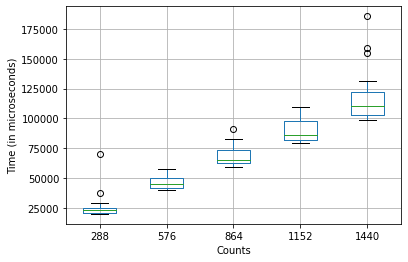

In [51]:
brute_cols, brute_perf_logs = get_counts_and_perf_logs(data_frames, brute_force_association_mining)
draw_box_plot(brute_cols, brute_perf_logs)

## Matlib Plots

In [63]:
def draw_plots(col_sets, perf_log_sets, color_sets, label_sets):
  plot_df_sets = []
  for cols, logs, color, label in zip(col_sets, perf_log_sets, color_sets, label_sets):
    df = pandas.DataFrame(logs,columns=cols)
    data = np.array(logs)
    y = data.mean(axis=0)
    x = cols
    avgs = []
    std_devs = []
    std_err = []
    for col in cols: 
      std_err.append(df[col].sem())
      avgs.append(df[col].mean()) 
      std_devs.append(df[col].std())
    error = np.array(std_err)
    std_dev = np.array(std_devs)
    plt.plot(x, y, 'k-', label=label)
    plt.fill_between(x, y-std_dev/2, y+std_dev/2, color=color)
    plt.fill_between(x, y-error/2, y+error/2, color='red')    
    data = {'count': cols, 'avg. time': avgs, 'std. deviation': std_devs, 'std. error': std_err}
    plot_df = pandas.DataFrame(data)
    plot_df_sets.append(plot_df)
  plt.xlabel("Count")
  plt.ylabel("Time (microseconds)")
  plt.legend()
  plt.show()
  return plot_df_sets

# Plot of measured time

## Scale down Brute Force results

In [75]:
brute_perf_logs = np.array(brute_perf_logs)
brute_perf_scaled_logs = brute_perf_logs/40

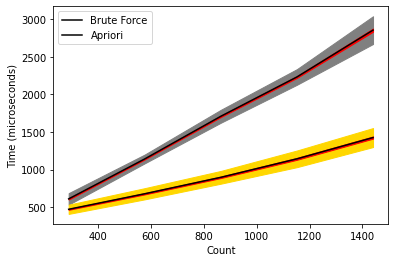

[   count    avg. time  std. deviation  std. error
 0    288   609.492000      152.872742   17.652224
 1    576  1141.552333      116.729163   13.478723
 2    864  1709.385333      171.942425   19.854201
 3   1152  2232.692667      208.126527   24.032381
 4   1440  2856.277000      369.459515   42.661510,
    count    avg. time  std. deviation  std. error
 0    288   470.960000      123.286465   14.235895
 1    576   677.826667      149.056163   17.211523
 2    864   896.746667      170.277206   19.661918
 3   1152  1142.733333      221.922578   25.625412
 4   1440  1425.973333      252.953845   29.208594]

In [76]:
draw_plots([brute_cols, apriori_cols], [brute_perf_scaled_logs, apriori_perf_logs], ['gray', 'gold'], ['Brute Force', 'Apriori'] )